In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pywt
from scipy.fft import fft2, ifft2, dct, idct
from sklearn.linear_model import Lasso
from numpy.random import default_rng
import os
import sys
import scipy.io
os.path.join("/Users/yuan/Library/Mobile Documents/com~apple~CloudDocs/CS Example/pytorch_wavelets")
sys.path.append("/Users/yuan/Library/Mobile Documents/com~apple~CloudDocs/CS Example/pytorch_wavelets")
from pytorch_wavelets import DWTForward, DWTInverse # (or import DWT, IDWT)


In [2]:
#Load files
# Change path to your .mat file
#mat_file_path = '/Users/yuan/Desktop/CS Example/brain.mat'
mat_file_path = '/Users/yuan/Desktop/CS Example/Phantom256.mat'

# Load the .mat file
#im = scipy.io.loadmat(mat_file_path)['data'].squeeze();res = 192; im = abs(im);min = np.min(im);max = np.max(im);im = (im - min)/max #real brain
im = scipy.io.loadmat(mat_file_path)['im'];res=256

### Specify Parameters
     Define subsampling pattern and sparsifying transformation


In [3]:
# Specify the sparsifying transformation method:
# Options:  "id": Identity transformation (no sparsification applied)
#           "dct": DCT transformation
#           "dwt" : haar wavelet
method = "haar"

# Specify the sampling method (change as needed)
# 1. "uniform": Uniform random sampling with a specified sampling rate.
# 2. "poisson": Poisson disk sampling pattern loaded from a pre-saved .mat file.
sampling = "poisson"; sampling_rate = None
#sampling = "uniform"; sampling_rate = 0.33

# Specify the size of the center calibration area (n x n region in the Fourier domain). 
#  -change as needed)
#  -This area is fully sampled to preserve low-frequency components.
n = 2

# Load or generate the subsampling mask based on the specified sampling method.
if sampling == "poisson":
    # Load a pre-defined sampling pattern from a .mat file.
    # Adjust the file path to the location of the saved mask file.
    mask = scipy.io.loadmat('/Users/yuan/Library/Mobile Documents/com~apple~CloudDocs/y=ADX/Paper Experiments/exp3_NLINV/pat_7_256_v0')['data'] 
    # Apply an FFT shift to center the mask.
    mask = abs(np.fft.fftshift(mask))
    sampling_rate = 1
elif sampling == "uniform":
    # For uniform random sampling, no pre-defined mask is loaded.
    # Instead, the mask is generated with the specified sampling rate later in the code.
    mask = None
   


### Next, define utility functions

In [4]:
if method == "id":
    def W(x): 
        return x
    def Wt(z): 
        return z[0]
elif method == "dct":
    def W(x): 
        return np.reshape(dct(dct(np.reshape(x, (res, res)), axis=0, norm='ortho'), axis=1, norm='ortho'), -1)
    def Wt(z): 
        coeffs = np.reshape(z, (res, res))
        return idct(idct(coeffs, axis=0, norm='ortho'), axis=1, norm='ortho').flatten()
    resolution = res**2
else:
    # Using haar wavelet
    xfm = DWTForward(J=4, mode='symmetric', wave='haar')  # Accepts all wave types available to PyWavelets
    ifm = DWTInverse(mode='symmetric', wave='haar')
    def W(x): 
        X = torch.tensor(np.expand_dims(np.expand_dims(im, 0), 0), dtype=torch.float32)
        Yl, Yh = xfm(X)
        LH = Yh[0];
        HL = Yh[1];HH = Yh[2];
        coeff = torch.concatenate([Yl.flatten(), LH.flatten(), HL.flatten(), HH.flatten()])
        #coeff = torch.concatenate([Yl.flatten(), LH.flatten()])
        return torch.tensor(coeff) #level 4
        #return Yl,Yh #level 1
    def Wt(z):
        Yl = z[0];
        Yh = [z[1],z[2],z[3]];
        #Yh = [z[1]];
        '''
        size = len(z) // 4
        m = int(np.sqrt(size))
        LL = z[:size].reshape(m,m)
        LH = z[size:2*size].reshape(m,m)
        HL = z[2*size:3*size].reshape(m,m)
        HH = z[3*size:].reshape(m,m)
        coeffs = (LL.clone().detach().requires_grad_(False), (LH.clone().detach().requires_grad_(False), HL.clone().detach().requires_grad_(False), HH.clone().detach().requires_grad_(False)))
        # Perform the inverse 2D Daubechies 4 (db4) wavelet transform
        reconstructed = pywt.idwt2(coeffs, 'db4')
        # Flatten the reconstructed signal back to 1D
        return torch.tensor(reconstructed.flatten())
        '''
        Y = ifm((Yl,Yh))
        return torch.squeeze(Y)

    
    
def subsampling_operator(res, sampling_rate, method, mask=None):
    total_pixels = res * res
    num_samples = round(sampling_rate * total_pixels)
    rng = default_rng()
    
    if method == "uniform":
        sample_indices = rng.choice(total_pixels, num_samples, replace=False)
        sample_indices[0:4] = [0,res-1,res**2-1,res**2-res-1];
        # Create center calibration area of size [2n,2n] filled with zeros
        mask0 = np.zeros((res, res));mask0[res // 2 - n:res // 2 + n, res // 2 - n:res // 2 + n] = 1;mask0 = np.fft.fftshift(mask0)
        sample_indices[0:4*n**2] = np.argwhere(mask0.ravel() == 1).squeeze()
    
    elif method == "radial":
        # Replace with radial sampling logic if needed
        pass
    elif method == "poisson":
        sample_indices = np.argwhere(mask.ravel() == 1).squeeze()

    # Create mask
    mask = np.zeros(res**2)
    mask[sample_indices] = 1
    mask = np.reshape(mask, (res, res))
    
    def F(x):
        return subsample(x, sample_indices, res)
    
    def Ft(y):
        return reconstruct(y, sample_indices, res)
    
    return F, Ft, mask

def subsample(x, sample_indices, res):
    y = torch.zeros(len(sample_indices))
    xf = fft2(torch.reshape(x, (res, res))) / res
    y = xf.flatten()[sample_indices]
    return y

def reconstruct(y, sample_indices, res):
    y0 = torch.zeros((res, res), dtype=torch.complex64)
    print(y0.dtype)
    y0.ravel()[sample_indices] = y
    print(y.dtype)
    return np.reshape(ifft2(y0) * res, -1)

def forward(x, mode):
    if mode == 1:
        return A(Wt(x))
    elif mode == 2:
        return W(At(x))


In [5]:
w = pywt.Wavelet('db4')
print(w)

Wavelet db4
  Family name:    Daubechies
  Short name:     db
  Filters length: 8
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       asymmetric
  DWT:            True
  CWT:            False


In [6]:
xfm = DWTForward(J=3, mode='symmetric', wave='haar')  # Accepts all wave types available to PyWavelets
ifm = DWTInverse(mode='symmetric', wave='haar')
X = torch.tensor(np.expand_dims(np.expand_dims(im, 0), 0), dtype=torch.float32)
Yl, Yh = xfm(X)
print(Yl.shape)
print(Yh[0].shape)
print(Yh[1].shape)
print(Yh[2].shape)
Y = ifm((Yl, Yh))
print(Y.shape)
print(np.linalg.norm(Y-X))

torch.Size([1, 1, 32, 32])
torch.Size([1, 1, 3, 128, 128])
torch.Size([1, 1, 3, 64, 64])
torch.Size([1, 1, 3, 32, 32])
torch.Size([1, 1, 256, 256])
1.2820481e-05


In [7]:
#get wavelet coefficient matrix
top = torch.cat((Yl.squeeze(), Yh[2].squeeze()[0]), dim=1)  # Shape [32, 64]
bottom = torch.cat((Yh[2].squeeze()[1], Yh[2].squeeze()[2]), dim=1)  # Shape [32, 64]
result1 = torch.cat((top, bottom), dim=0)  # Shape [64, 64]

top = torch.cat((result1, Yh[1].squeeze()[0]), dim=1)  # Shape [32, 64]
bottom = torch.cat((Yh[1].squeeze()[1], Yh[1].squeeze()[2]), dim=1)  # Shape [32, 64]
result2 = torch.cat((top, bottom), dim=0)  # Shape [64, 64]

top = torch.cat((result2, Yh[0].squeeze()[0]), dim=1)  # Shape [32, 64]
bottom = torch.cat((Yh[0].squeeze()[1], Yh[0].squeeze()[2]), dim=1)  # Shape [32, 64]
result3 = torch.cat((top, bottom), dim=0)  # Shape [64, 64]
#plt.imshow( np.log1p(abs(result3.squeeze().cpu().numpy())),cmap = 'gray')

### Finally, solve the l1 minimization problem

#### Need to specify optimizer parameters

In [8]:
optimizer_handle = lambda x:Adam(x, lr=1e-3)
#optimizer = lambda x: SGD(x, lr=0.01, momentum=0.1)

# Number of iterations for optimization
num_iterations = 25000


In [9]:
from torch.optim import Adam,SGD
from torch.fft import fft2, ifft2

# Set up forward and adjoint operators
F, Ft, mask = subsampling_operator(res, sampling_rate, sampling, mask)
A = lambda x: F(Wt(x))
At = lambda x: W(Ft(x))

# Generate the measurements (observed signal)
y = F(torch.tensor(im))

if method =="haar":
    # Initialize x as a tensor with requires_grad=True for optimization
    x0 = torch.zeros_like(Yl, dtype=torch.float32, requires_grad=True)
    x1 = torch.zeros_like(Yh[0], dtype=torch.float32, requires_grad=True)
    x2 = torch.zeros_like(Yh[1], dtype=torch.float32, requires_grad=True)
    x3= torch.zeros_like(Yh[2], dtype=torch.float32, requires_grad=True)
    
    x = [x0,x1,x2,x3]
    #x = [x0,x1]

elif method =="id":
    x0 = torch.zeros_like(torch.tensor(im), dtype=torch.float32, requires_grad=True)
    x = [x0]

optimizer = optimizer_handle(x)

# L1 regularization term
def l1_norm(x):
    return sum(torch.sum(torch.abs(xi)) for xi in x)

# Loss function
def loss_function(x, y):
    # A(x) - y should be close to zero
    Ax = A(x)
    residual = torch.norm(Ax - y, 'fro')
    
    # L1 norm of x (sparsity regularization)
    l1_penalty = l1_norm(x)
    
    return residual + 1*  1e-3 * l1_penalty  # Adjust lambda for regularization

# Optimization loop
for i in range(num_iterations):
    optimizer.zero_grad()  # Clear previous gradients
    
    # Compute the loss
    loss = loss_function(x, y)     
    # Backpropagate the gradients
    loss.backward()
    
    # Update the solution using the optimizer
    optimizer.step()
   
    # Print the loss every 100 iterations
    if i % 1000 == 0:
        print(f"Iteration {i}, Loss: {loss.item()}")

# Plot the original and reconstructed images
x_reconstructed = x

Iteration 0, Loss: 58.20936600557372
Iteration 1000, Loss: 35.07039149384773
Iteration 2000, Loss: 17.420073746360806
Iteration 3000, Loss: 6.540707147779912
Iteration 4000, Loss: 5.373737918705219
Iteration 5000, Loss: 4.580108810541025
Iteration 6000, Loss: 3.948811655107722
Iteration 7000, Loss: 3.4686880473385338
Iteration 8000, Loss: 3.1354833919659724
Iteration 9000, Loss: 2.9242145739983703
Iteration 10000, Loss: 2.8045120978946105
Iteration 11000, Loss: 2.750333736784758
Iteration 12000, Loss: 2.7289872640340285
Iteration 13000, Loss: 2.720431567789487
Iteration 14000, Loss: 2.717124219228801
Iteration 15000, Loss: 2.7156647962032476
Iteration 16000, Loss: 2.7147138138126388
Iteration 17000, Loss: 2.7144063177425983
Iteration 18000, Loss: 2.7139320618497873
Iteration 19000, Loss: 2.713587965958717
Iteration 20000, Loss: 2.713807504071766
Iteration 21000, Loss: 2.713414657361938
Iteration 22000, Loss: 2.7133401491486713
Iteration 23000, Loss: 2.7135867539573475
Iteration 24000, 

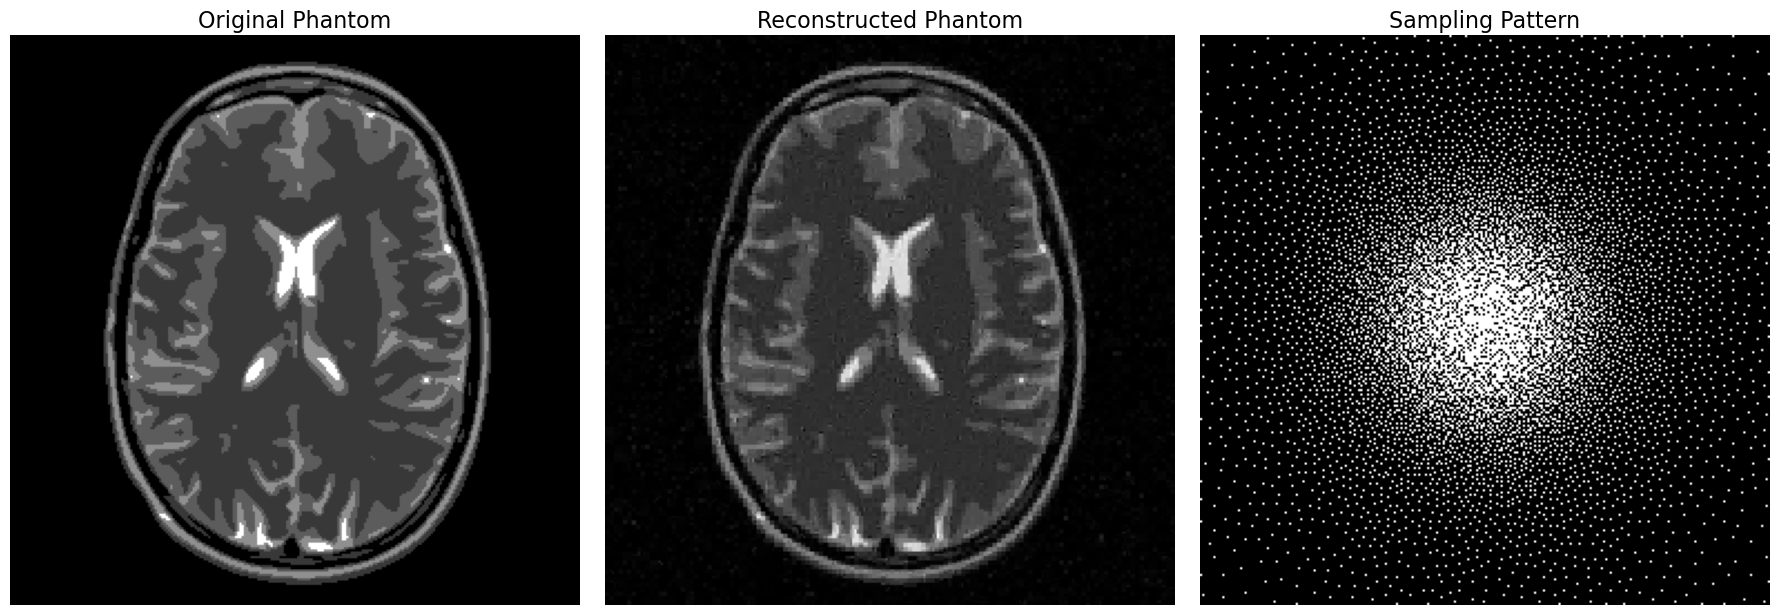

In [10]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot the mask
axs[2].imshow(np.fft.ifftshift(mask), cmap='gray')
axs[2].set_title('Sampling Pattern', fontsize=16)
axs[2].axis('off')  # Hide axes

# Plot the reconstructed image
reconstructed = abs(np.reshape(Wt(x_reconstructed).detach().clone().numpy(), (res, res)))
axs[1].imshow(abs(reconstructed), cmap='gray')
axs[1].set_title('Reconstructed Phantom', fontsize=16)
axs[1].axis('off')

# Plot the original image
original = abs(np.reshape(im, (res, res)))
#axs[0].imshow( np.log1p(abs(result3.squeeze().cpu().numpy())),cmap = 'gray')
axs[0].imshow(original,cmap='gray')
axs[0].set_title('Original Phantom', fontsize=16)
axs[0].axis('off')

# Adjust layout and show the plot
plt.tight_layout()
#plt.savefig('uniform_id_3x.png', dpi=300, format='png', bbox_inches='tight') #save figure to path
plt.show()